In [1]:
import preprocessing.preprocessing as pp
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Preprocessing and visualization

In [2]:
df = pp.load_data("english_cleaned_lyrics.csv")
df = pp.preprocess_data(df)
df = df[['lyrics', 'genre']]
df

,lyrics,genre
0,oh baby know im gonna cut right chase woman ma...,Pop
1,playin everything easy like seem sure still wa...,Pop
2,search tenderness isnt hard find love need liv...,Pop
3,oh oh oh oh oh oh wrote book stand title book ...,Pop
4,party people people party popping sitting arou...,Pop
...,...,...
218205,gotta say boy couple date youre hand outright ...,Country
218206,helped find diamond ring made try everything t...,Country
218207,look couple corner booth look lot like shes lo...,Country
218208,fly mortal earth im measured depth girth fathe...,Country


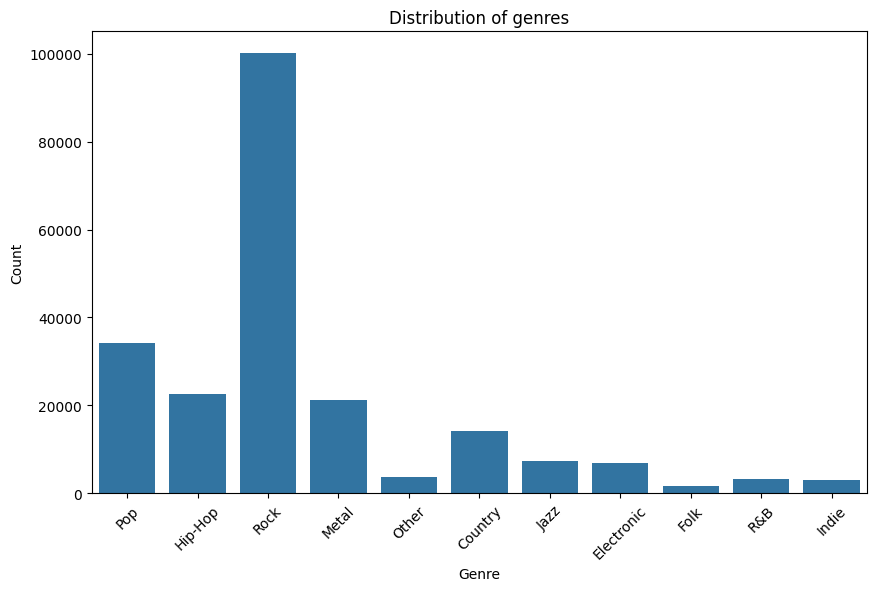

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df)

plt.title('Distribution of genres') 
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

100053 30000


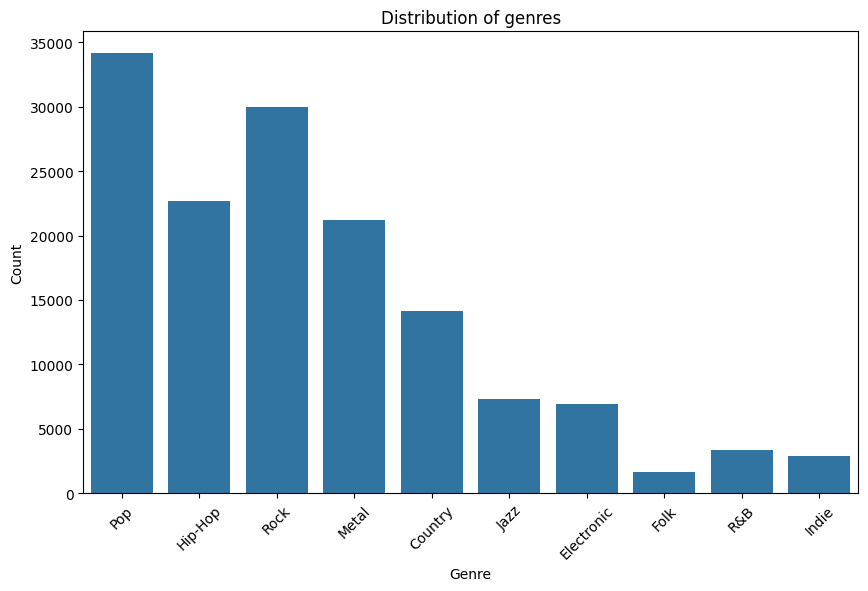

In [4]:
# Too many rocks songs, let's reduce the number of rock songs
df = df[~(df['genre'] == 'Other')]

rocks_indices = df[df['genre'] == 'Rock'].index

num_rocks_to_keep = 30000
num_rocks_current = len(rocks_indices)

print(num_rocks_current, num_rocks_to_keep)

if num_rocks_current > num_rocks_to_keep:
    keep_indices = np.random.choice(rocks_indices, num_rocks_to_keep, replace=False)
else:
    keep_indices = rocks_indices

df = df.drop(index=set(rocks_indices) - set(keep_indices))

plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df)

plt.title('Distribution of genres') 
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

## Training Word2vec

In [5]:
import importlib
importlib.reload(pp)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicolas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nicolas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/nicolas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'preprocessing.preprocessing' from '/home/nicolas/Prog/python-projects/NLP/nlp-project/src/preprocessing/preprocessing.py'>

In [6]:
df['tokenized_lyrics'] = df['lyrics'].apply(word_tokenize)

In [7]:
tokenized_lyrics = df['tokenized_lyrics'].to_list()
len(tokenized_lyrics)

144371

## Creating the word2Vec model
The model seemed to work better by defining each lyrics as a sentence, instead of using sents_tokenize on each lyrics

In [8]:
model = Word2Vec(sentences=tokenized_lyrics, vector_size=50, window=5, min_count=1, workers=4)
word_vectors = model.wv
word_vectors.save("word2vec.wordvectors") # Store the words and their trained embeddings
del model

In [9]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

def print_similar_words(words):
    for word in words:
        if word in wv:
            sims = wv.most_similar(word, topn=10)
            print(f"Words most similar to '{word}':")
            for sim in sims:
                print(f"{sim[0]} ({sim[1]:.4f})")
        else:
            print(f"Word '{word}' not in vocabulary.")

query_words = ['love', 'hate', 'happy', 'sad', 'baby', 'night', 'music']

print_similar_words(query_words)

Words most similar to 'love':
baby (0.7595)
true (0.7435)
loving (0.7386)
know (0.7153)
oh (0.7026)
darlin (0.6965)
feel (0.6958)
want (0.6924)
cause (0.6920)
heart (0.6915)
Words most similar to 'hate':
jealousy (0.6458)
envy (0.6326)
trust (0.6225)
jealous (0.6119)
fake (0.6000)
sque (0.5973)
hater (0.5543)
pity (0.5540)
fucking (0.5508)
deserve (0.5481)
Words most similar to 'happy':
unhappy (0.7838)
glad (0.7765)
sad (0.6702)
happier (0.6383)
today (0.6236)
worthwhile (0.5833)
grateful (0.5758)
wonderful (0.5656)
deseri (0.5534)
loving (0.5473)
Words most similar to 'sad':
sadder (0.6918)
happy (0.6702)
unhappy (0.6671)
cry (0.6611)
lonely (0.6511)
lonesome (0.6265)
repining (0.5999)
bruteful (0.5867)
angry (0.5866)
glad (0.5853)
Words most similar to 'baby':
babe (0.8698)
girl (0.8224)
ooh (0.7797)
oh (0.7788)
love (0.7595)
want (0.7589)
cause (0.7531)
yeah (0.7510)
know (0.7418)
tonight (0.7254)
Words most similar to 'night':
saturday (0.7371)
tonight (0.6890)
sleepless (0.6781)


In [10]:
wv.most_similar('happy', topn=10)

[('unhappy', 0.783795177936554),
 ('glad', 0.7765421271324158),
 ('sad', 0.6702190637588501),
 ('happier', 0.6382518410682678),
 ('today', 0.6236181855201721),
 ('worthwhile', 0.5833258628845215),
 ('grateful', 0.5757834911346436),
 ('wonderful', 0.565553605556488),
 ('deseri', 0.5533761978149414),
 ('loving', 0.5472732186317444)]

In [11]:
df

,lyrics,genre,tokenized_lyrics
0,oh baby know im gonna cut right chase woman ma...,Pop,"[oh, baby, know, im, gon, na, cut, right, chas..."
1,playin everything easy like seem sure still wa...,Pop,"[playin, everything, easy, like, seem, sure, s..."
2,search tenderness isnt hard find love need liv...,Pop,"[search, tenderness, isnt, hard, find, love, n..."
3,oh oh oh oh oh oh wrote book stand title book ...,Pop,"[oh, oh, oh, oh, oh, oh, wrote, book, stand, t..."
4,party people people party popping sitting arou...,Pop,"[party, people, people, party, popping, sittin..."
...,...,...,...
218205,gotta say boy couple date youre hand outright ...,Country,"[got, ta, say, boy, couple, date, youre, hand,..."
218206,helped find diamond ring made try everything t...,Country,"[helped, find, diamond, ring, made, try, every..."
218207,look couple corner booth look lot like shes lo...,Country,"[look, couple, corner, booth, look, lot, like,..."
218208,fly mortal earth im measured depth girth fathe...,Country,"[fly, mortal, earth, im, measured, depth, girt..."


In [12]:
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')

def document_vector(words):
    word_vectors = np.array([wv[word] for word in words if word in wv])

    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [13]:
document_vector("hello i'm gustave")

array([-0.46462882, -2.0548842 , -0.24425317,  1.6852483 ,  1.8379141 ,
        1.5513929 , -0.5754874 ,  1.0302233 , -0.0373085 , -0.43133795,
        0.3649213 ,  0.0279478 ,  0.6474332 ,  0.88741404,  1.1495076 ,
       -0.42294043, -1.4333247 , -0.22130607, -1.16475   , -1.4995112 ,
        0.25956792, -0.9137274 , -0.01518799,  0.6333443 , -0.96820164,
       -1.1121137 , -1.018114  , -0.10582924,  0.22823374, -0.20227902,
        1.6280949 ,  0.46317357, -1.1061225 , -0.41951996, -0.32022682,
        0.3713706 ,  1.4252661 , -0.8022016 , -1.1080768 , -0.5285998 ,
       -0.9665012 , -0.42659342,  0.05413447, -1.0446521 ,  1.4122009 ,
       -2.5978808 ,  0.47141215, -0.35983655, -0.46191853,  1.7900083 ],
      dtype=float32)

## Training and test sets for Word2vec

In [14]:
X = df['tokenized_lyrics'].to_list()
y = df['genre'].to_list()

X = np.array([document_vector(lyrics) for lyrics in X])


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (115496, 50)


## Training: Logistic Regression with tf-idf or Word2vec features

In [16]:
model = LogisticRegression(random_state=42, penalty = 'l2', max_iter = 100000, class_weight='balanced')
#model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range = (1,1)), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l1', max_iter = 1000))


In [17]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

     Country       0.37      0.42      0.40      2789
  Electronic       0.13      0.26      0.18      1410
        Folk       0.06      0.32      0.09       359
     Hip-Hop       0.74      0.77      0.75      4500
       Indie       0.07      0.31      0.11       619
        Jazz       0.22      0.35      0.27      1486
       Metal       0.66      0.72      0.69      4255
         Pop       0.50      0.15      0.23      6889
         R&B       0.06      0.25      0.09       652
        Rock       0.41      0.10      0.16      5916

    accuracy                           0.37     28875
   macro avg       0.32      0.37      0.30     28875
weighted avg       0.47      0.37      0.37     28875



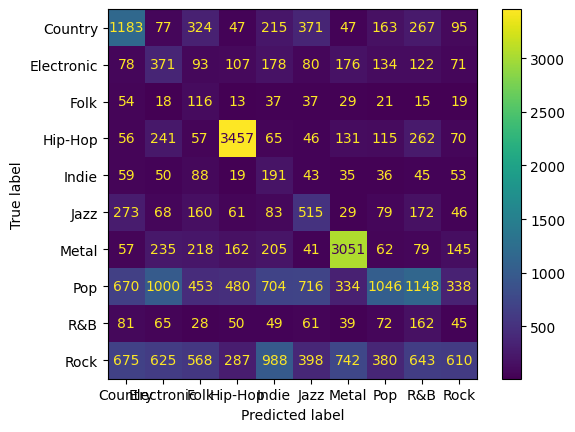

In [18]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

# Let's try our model with another genre distribution

In [19]:
df = pp.adjust_genre_distribution(df)
df

,lyrics,genre,tokenized_lyrics
0,oh baby know im gonna cut right chase woman ma...,Pop,"[oh, baby, know, im, gon, na, cut, right, chas..."
1,playin everything easy like seem sure still wa...,Pop,"[playin, everything, easy, like, seem, sure, s..."
2,search tenderness isnt hard find love need liv...,Pop,"[search, tenderness, isnt, hard, find, love, n..."
3,oh oh oh oh oh oh wrote book stand title book ...,Pop,"[oh, oh, oh, oh, oh, oh, wrote, book, stand, t..."
4,party people people party popping sitting arou...,Pop,"[party, people, people, party, popping, sittin..."
...,...,...,...
218205,gotta say boy couple date youre hand outright ...,Country/Folk,"[got, ta, say, boy, couple, date, youre, hand,..."
218206,helped find diamond ring made try everything t...,Country/Folk,"[helped, find, diamond, ring, made, try, every..."
218207,look couple corner booth look lot like shes lo...,Country/Folk,"[look, couple, corner, booth, look, lot, like,..."
218208,fly mortal earth im measured depth girth fathe...,Country/Folk,"[fly, mortal, earth, im, measured, depth, girt..."


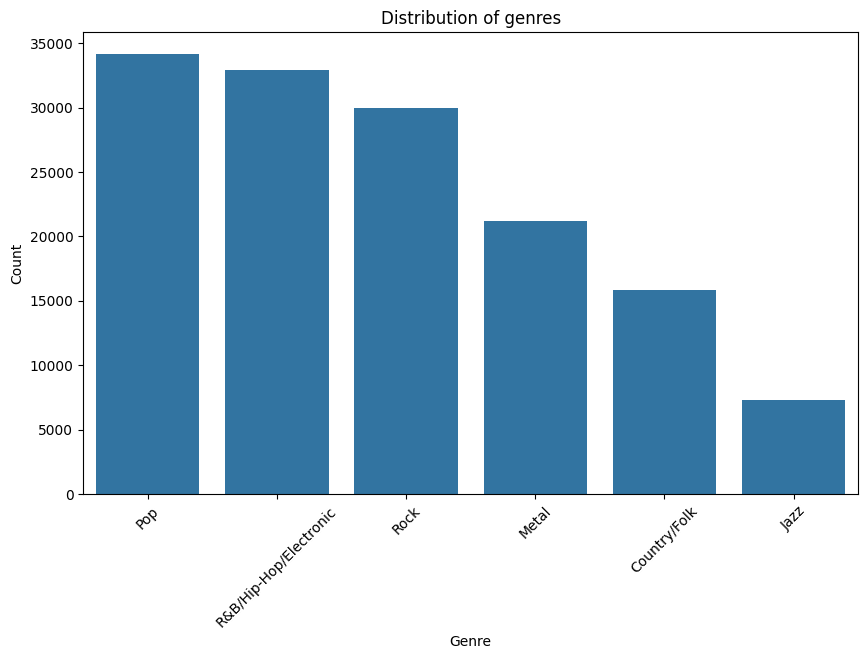

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='genre', data=df)

plt.title('Distribution of genres') 
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

In [21]:
X = df['tokenized_lyrics'].to_list()
y = df['genre'].to_list()

X = np.array([document_vector(lyrics) for lyrics in X])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

print(f"Features dimension: {X_train.shape}")

Features dimension: (113148, 50)


In [23]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
                         precision    recall  f1-score   support

          Country/Folk       0.37      0.50      0.43      3095
                  Jazz       0.21      0.46      0.29      1541
                 Metal       0.62      0.76      0.68      4276
                   Pop       0.49      0.38      0.43      6842
R&B/Hip-Hop/Electronic       0.71      0.62      0.66      6627
                  Rock       0.41      0.31      0.35      5907

              accuracy                           0.50     28288
             macro avg       0.47      0.50      0.47     28288
          weighted avg       0.52      0.50      0.50     28288



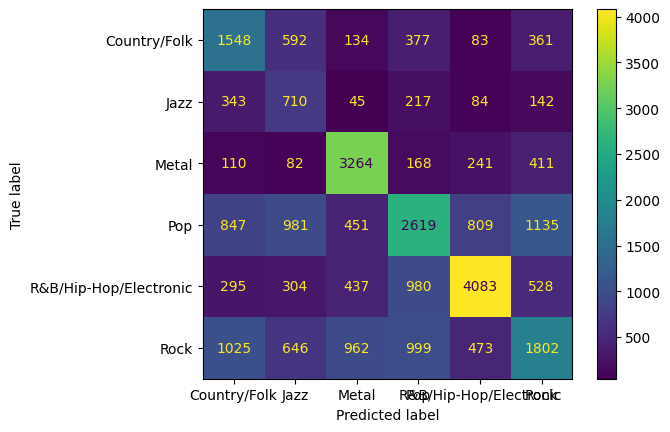

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()